In [4]:
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
games = [" Call of Duty: Black Ops 6", " Call of Duty: Black Ops Cold War", " Call of Duty: Modern Warfare",
         " Call of Duty: Modern Warfare II", " Call of Duty: Modern Warfare III", " Call of Duty: Vanguard"]

def parse_games(filename):
    print(filename)
    df = pd.DataFrame()
    game_processed = list()
    HTMLFile = open(filename, "r", encoding="utf8").read()
    S = BeautifulSoup(HTMLFile, "html.parser")
    tables = S.find_all('table')
    for table in tables:
        previous_tag = table.find_previous('h2')
        if previous_tag and previous_tag.get_text() == 'Multiplayer Match Data (reverse chronological)':
            previous_h1_tag = table.find_previous('h1')
            game_name = previous_h1_tag.get_text()
            if game_name in games and game_name not in game_processed:
                print(game_name)
                headers = [header.get_text() for header in table.find_all('th')]
                rows = []
                for row in table.find_all('tr')[1:]:  # Skip the first row (header)
                    cols = [col.get_text() for col in row.find_all('td')]
                    rows.append(cols)
                print(f'Number of games found: {len(rows)}')
                data = pd.DataFrame(columns=headers, data=rows)
                data['Game Name'] = game_name
                df = pd.concat([df, data])
                game_processed.append(game_name)

    return df

In [ ]:
glovalidf = parse_games('data/33753255-ACTIVISION_ACCOUNT.html')
glovalidf['Player'] = 'Glovali'
mystyydf = parse_games('data/33753517-ACTIVISION_ACCOUNT.html')
mystyydf['Player'] = 'Mystyy'

df = pd.concat([glovalidf, mystyydf])

data/33753255-ACTIVISION_ACCOUNT.html
 Call of Duty: Black Ops 6
Number of games found: 587
 Call of Duty: Modern Warfare
Number of games found: 34
 Call of Duty: Modern Warfare II
Number of games found: 2930
 Call of Duty: Modern Warfare III
Number of games found: 2222
 Call of Duty: Vanguard
Number of games found: 1093
data/33753517-ACTIVISION_ACCOUNT.html
 Call of Duty: Black Ops 6
Number of games found: 971
 Call of Duty: Modern Warfare
Number of games found: 111


In [7]:
pd.options.mode.chained_assignment = None  # default='warn'

def process_df(df):
    dfa = df[['Player', 'Match ID', 'Game Name', 'UTC Timestamp', 'Kills', 'Deaths', 'Game Type', 'Match Start Timestamp', 'Match End Timestamp', 'Map', 'Match Outcome', 'Skill', 'Score', 'Shots', 'Hits', 'Assists', 'Longest Streak', 'Headshots', 'Damage Done', 'Match XP']]
    dfa['UTC Timestamp'] = pd.to_datetime(dfa['UTC Timestamp'])
    dfa['Match Start Timestamp'] = pd.to_datetime(dfa['Match Start Timestamp'])
    dfa['Match End Timestamp'] = pd.to_datetime(dfa['Match End Timestamp'])
    dfa['Kills'] = dfa['Kills'].astype(int)
    dfa['Deaths'] = dfa['Deaths'].astype(int)
    dfa['Skill'] = dfa['Skill'].astype(float)
    dfa['Score'] = dfa['Score'].astype(int)
    dfa['Shots'] = dfa['Shots'].astype(float)
    dfa['Hits'] = dfa['Hits'].astype(float)
    dfa['Assists'] = dfa['Assists'].astype(int)
    dfa['Longest Streak'] = dfa['Longest Streak'].astype(int)
    dfa['Headshots'] = dfa['Headshots'].astype(int)
    dfa['Damage Done'] = dfa['Damage Done'].astype(float)
    dfa['Match XP'] = dfa['Match XP'].astype(float)

    seconds = ((dfa['Match End Timestamp'] - dfa['Match Start Timestamp']).values / 1000000000).astype(float)
    minutes = seconds / 60
    dfa['SPM'] = dfa['Score'] / minutes

    dfa['Accuracy'] = (100 / dfa['Shots']) * dfa['Hits']

    return dfa

dfa = process_df(df)

In [8]:
from datetime import datetime

def add2boxpatchvline(game_name):
    if game_name == ' Call of Duty: Black Ops 6':
        # plt.axvline(datetime(2024, 12, 23, 20, 30), c='green', label = 'Bought skin')
        plt.axvline(datetime(2024, 12, 4, 19, 00), c='red', label = '2box patch')

def get_game_data(game_name, ranged=None):
    dfc = dfa[dfa['Game Name'] == game_name]

    if ranged is not None:
        dfc = dfc.loc[(dfc['UTC Timestamp'] >= ranged[0]) & (dfc['UTC Timestamp'] <= ranged[1])]

    m = dfc[dfc['Player'] == 'Mystyy']
    g = dfc[dfc['Player'] == 'Glovali']
    
    return m, g

def plot_game(game_name, same_game=False, ranged=None):
    m, g = get_game_data(game_name, ranged)

    if same_game:
        m = m[m['Match ID'].isin(g['Match ID'])]
        g = g[g['Match ID'].isin(m['Match ID'])]

    plt.figure(figsize=(10, 10))
    plt.title(f'{game_name}: Skill')
    add2boxpatchvline(game_name)
    plt.plot(m['UTC Timestamp'], m['Skill'], label='Mystyy')
    plt.plot(g['UTC Timestamp'], g['Skill'], label='Glovali')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.figure(figsize=(10, 10))
    plt.title(f'{game_name}: K/D')
    add2boxpatchvline(game_name)
    plt.scatter(m['UTC Timestamp'], m['Kills'] / m['Deaths'], label='Mystyy')
    plt.scatter(g['UTC Timestamp'], g['Kills'] / g['Deaths'], label='Glovali')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.figure(figsize=(10, 10))
    plt.title(f'{game_name}: Score')
    add2boxpatchvline(game_name)
    plt.scatter(m['UTC Timestamp'], m['Score'], label='Mystyy')
    plt.scatter(g['UTC Timestamp'], g['Score'], label='Glovali')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.figure(figsize=(10, 10))
    plt.title(f'{game_name}: Kills')
    add2boxpatchvline(game_name)
    plt.scatter(m['UTC Timestamp'], m['Kills'], label='Mystyy')
    plt.scatter(g['UTC Timestamp'], g['Kills'], label='Glovali')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.figure(figsize=(10, 10))
    plt.title(f'{game_name}: Accuracy')
    add2boxpatchvline(game_name)
    plt.scatter(m['UTC Timestamp'], m['Accuracy'], label='Mystyy')
    plt.scatter(g['UTC Timestamp'], g['Accuracy'], label='Glovali')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.figure(figsize=(10, 10))
    plt.title(f'{game_name}: SPM')
    add2boxpatchvline(game_name)

    plt.scatter(m['UTC Timestamp'], m['SPM'], label='Mystyy')
    plt.scatter(g['UTC Timestamp'], g['SPM'], label='Glovali')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


<Axes: title={'center': 'Skill'}, xlabel='[Player, Box]'>

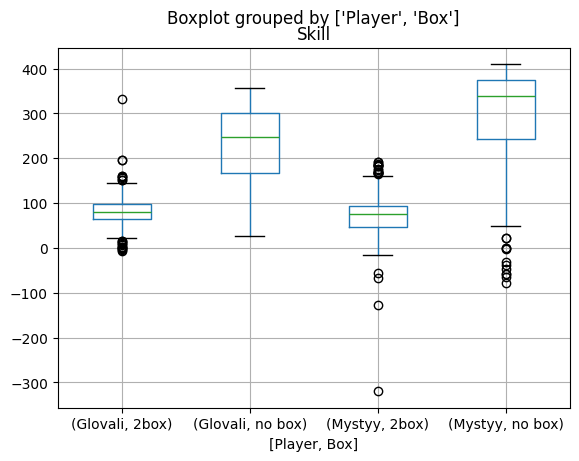

In [9]:
dfc = dfa[dfa['Game Name'] == ' Call of Duty: Black Ops 6']
dfc['Box'] = "2box"
dfc.loc[(dfc['UTC Timestamp'] > '2024-12-04 00:00:00'), 'Box'] = "no box"

fig = plt.figure()
ax = fig.gca()
dfc.boxplot(ax = ax, column='Skill', by=['Player', 'Box'])

<Axes: title={'center': 'Kills'}, xlabel='[Game Type, Player]'>

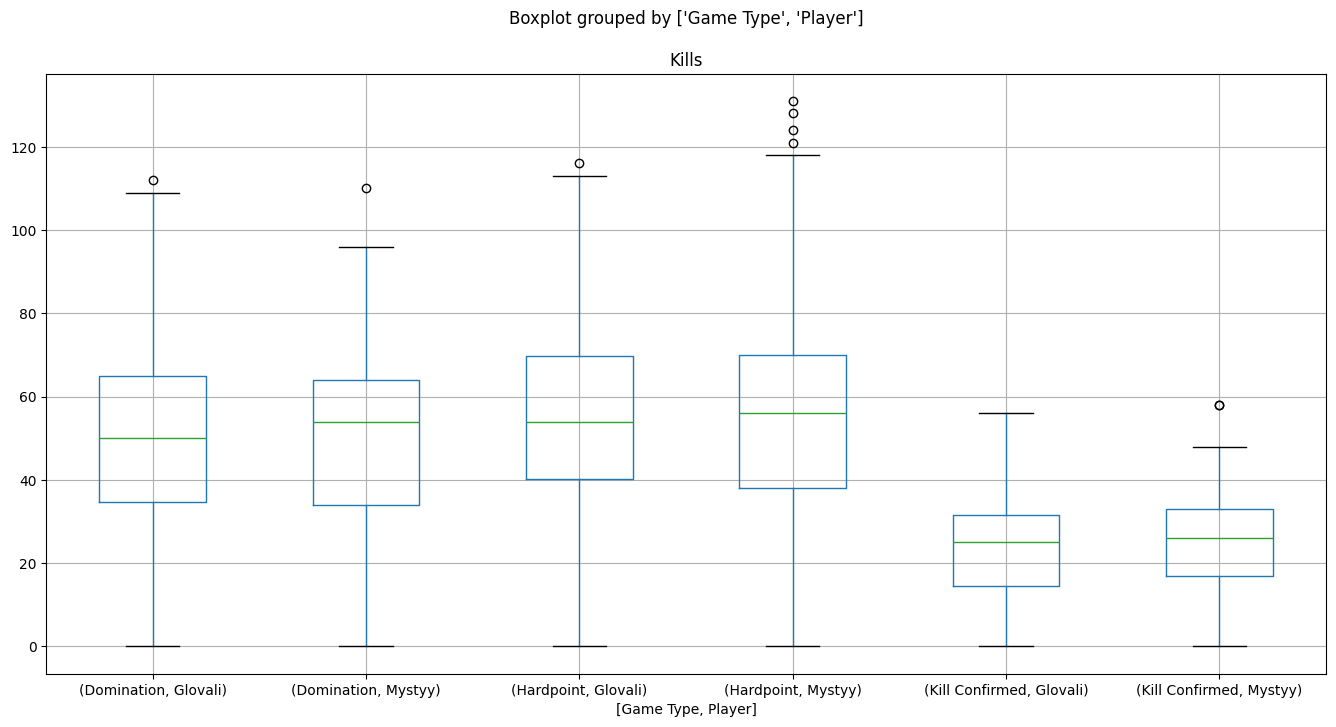

In [10]:
fig = plt.figure(figsize=(16, 8))
gamemodes = ['Domination', 'Hardpoint', 'Kill Confirmed']
dfc[dfc['Game Type'].isin(gamemodes)].boxplot(ax = fig.gca(), column='Kills', by=['Game Type', 'Player'])

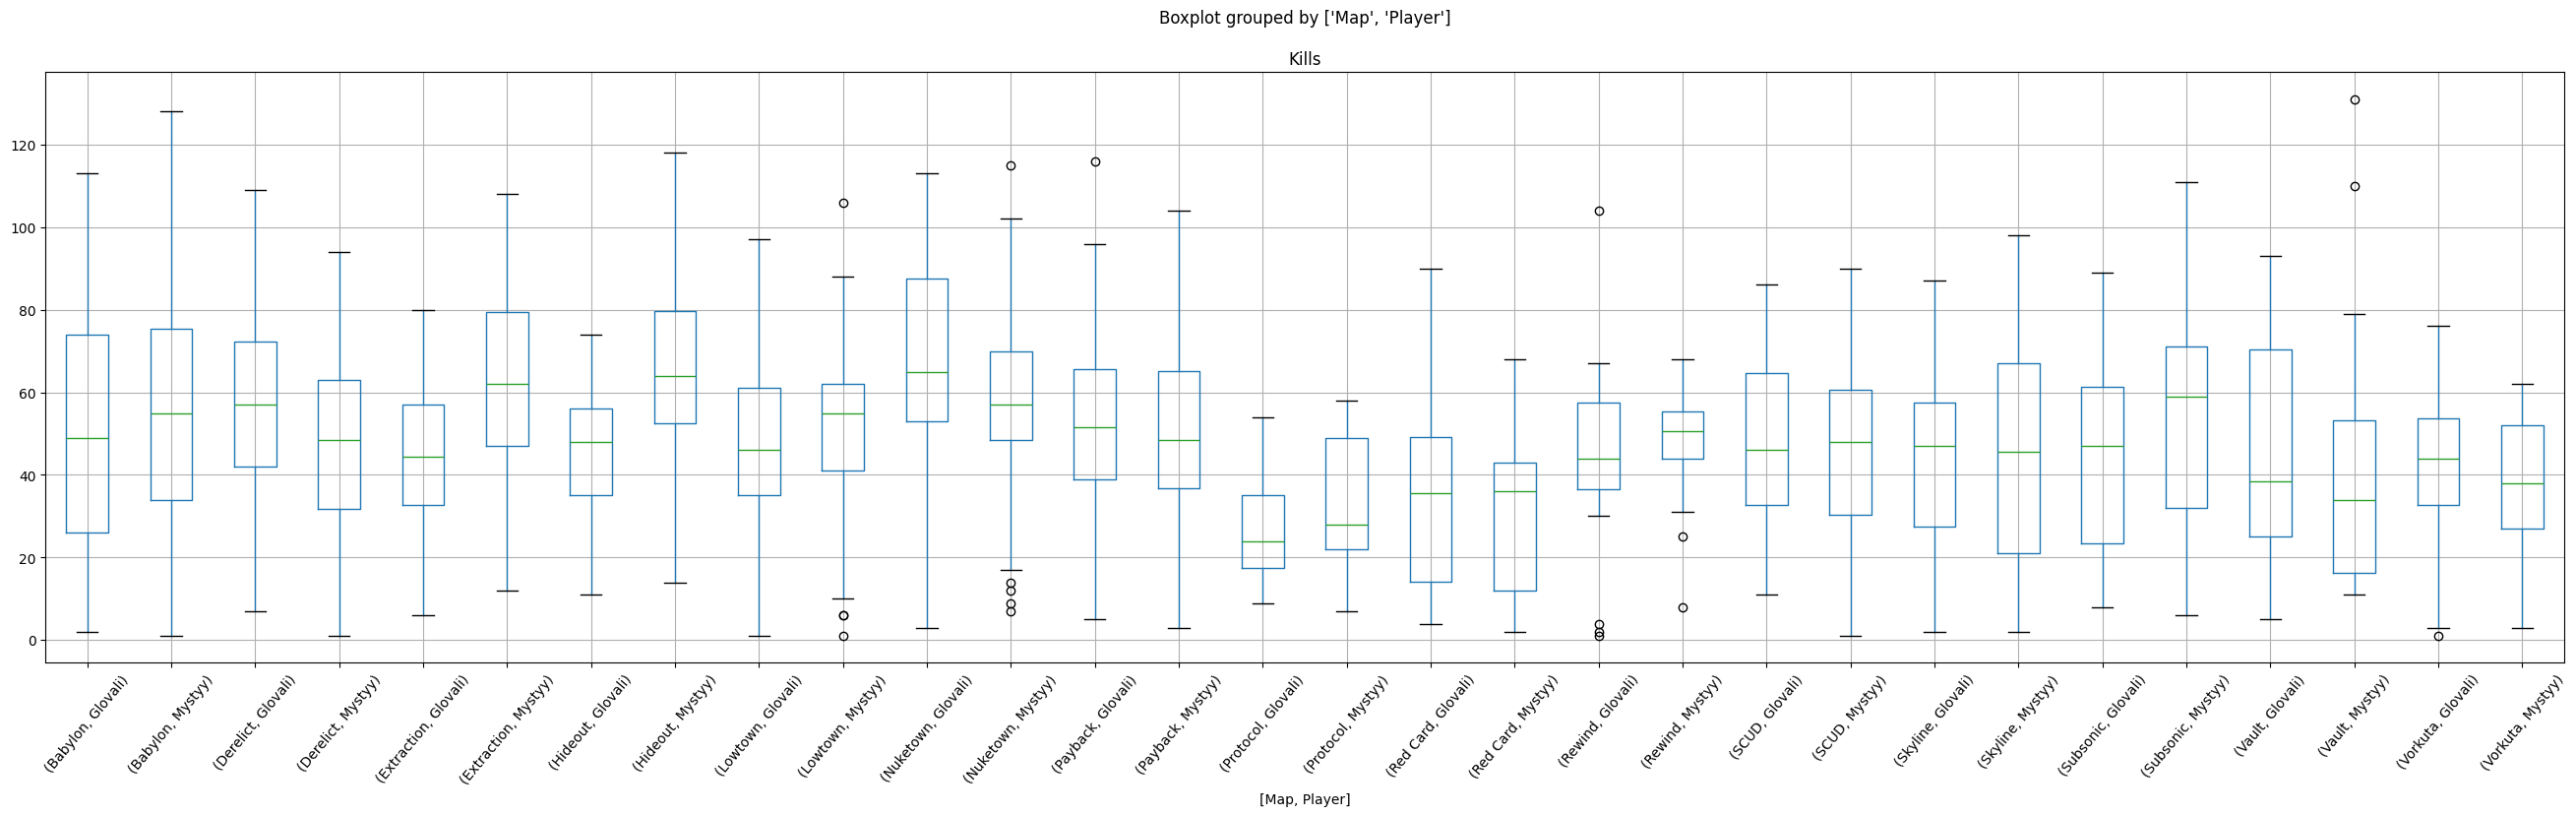

In [11]:
fig = plt.figure(figsize=(32, 8))
maps = ['Babylon', 'Derelict', 'Extraction', 'Hideout', 'Lowtown', 'Nuketown', 'Payback', 'Protocol', 'Red Card', 'Rewind', 'SCUD', 'Skyline', 'Subsonic', 'Vault', 'Vorkuta']
dfc[(dfc['Kills'] > 0) & (dfc['Map'].isin(maps))].boxplot(ax = fig.gca(), column='Kills', by=['Map', 'Player'])
plt.xticks(rotation=50);

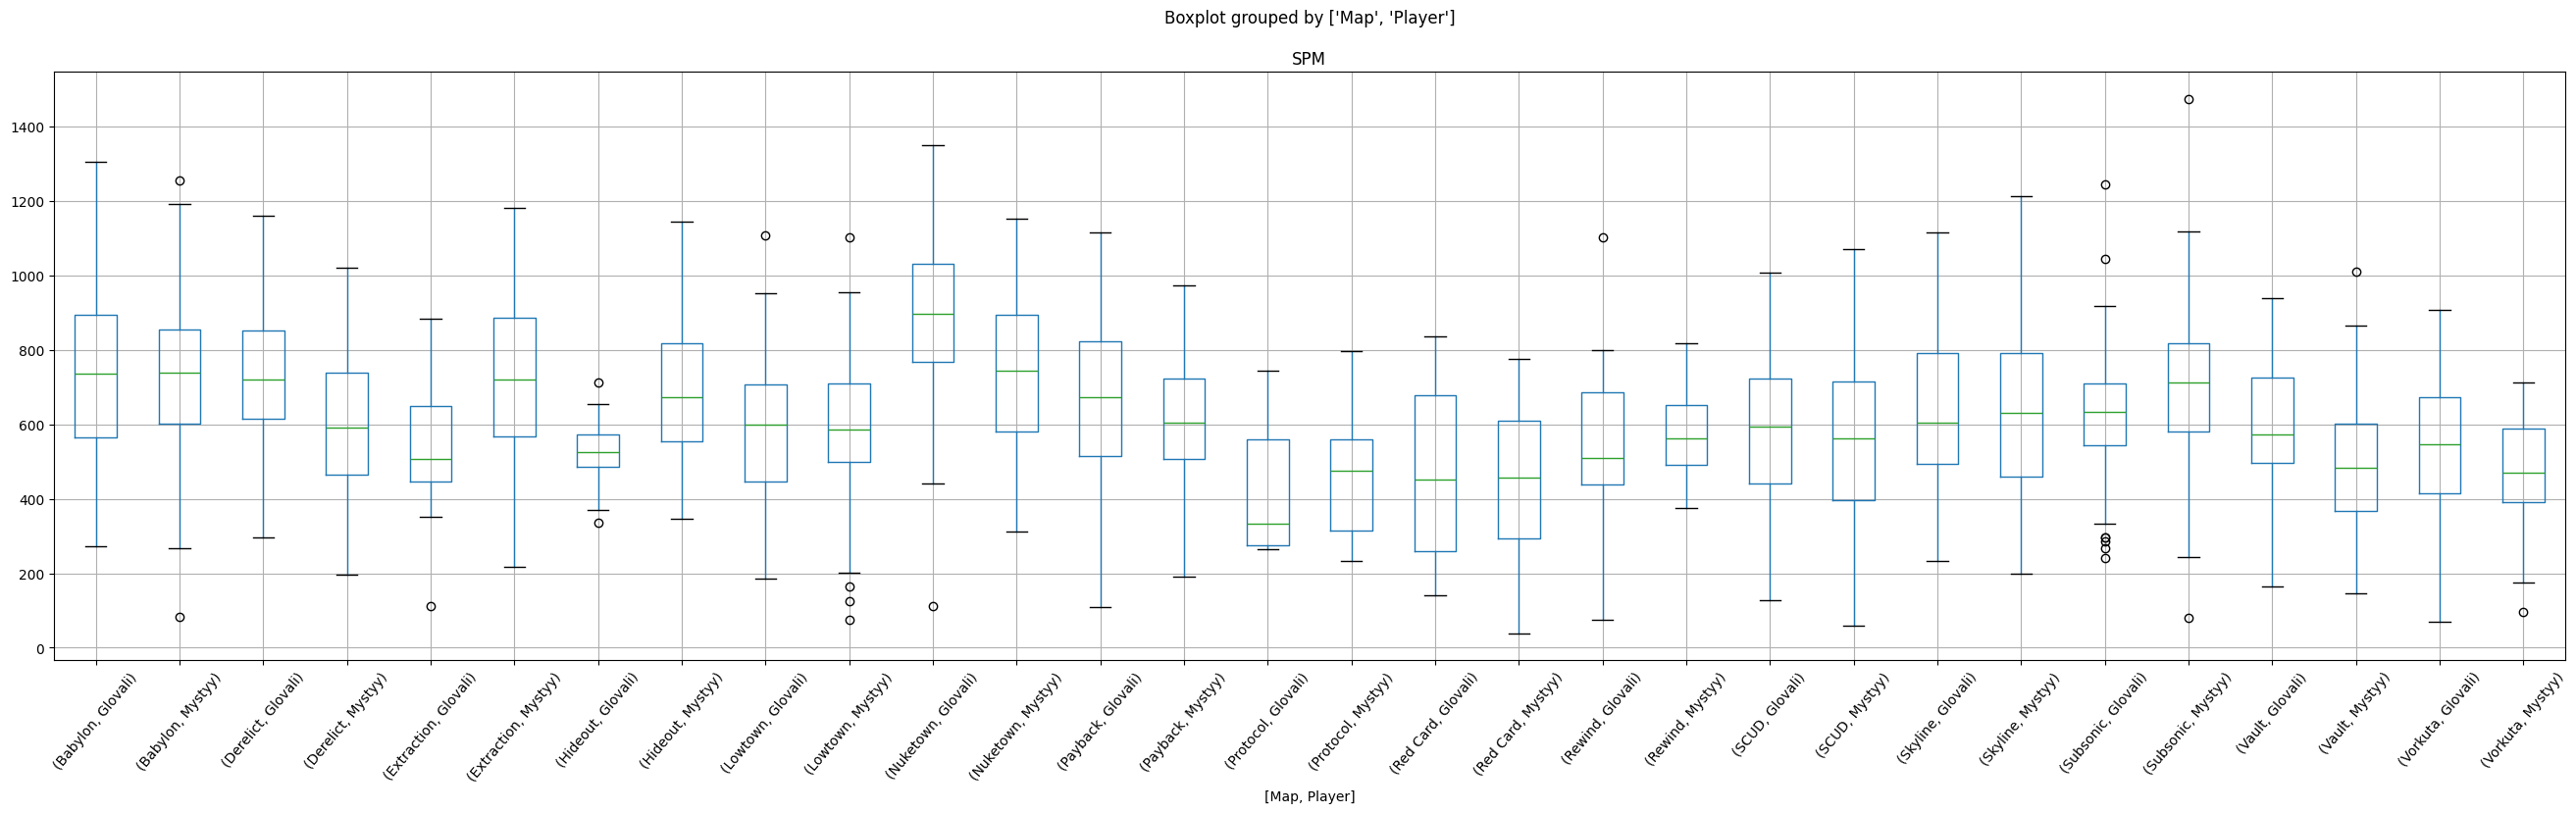

In [12]:
fig = plt.figure(figsize=(32, 8))
dfc[(dfc['Kills'] > 0) & (dfc['Map'].isin(maps))].boxplot(ax = fig.gca(), column='SPM', by=['Map', 'Player'])
plt.xticks(rotation=50);

In [13]:
nooob = dfc[dfc['Skill'] < 0]
nooob.T

,554,555,566,0,1,2,3,4,5,6,7,870,871,872,873,874,956,957,958,970
Player,Glovali,Glovali,Glovali,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy,Mystyy
Match ID,1090495663100827162,383082385926293785,1591714906552231708,8319957998521288790,17770733550568923665,12637207405214351781,7563238243423619919,3927424266097382912,12821471151380892591,6869549648408912761,2768733547809769189,6027247045056337226,283477973865123759,4818465858312808304,8288492018130938081,2198463094510418685,15322547060979347687,3677874614409847270,2547554386028143095,10156829400479827623
Game Name,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6,Call of Duty: Black Ops 6
UTC Timestamp,2024-10-25 08:49:28,2024-10-25 08:36:00,2024-10-24 18:12:13,2025-01-25 20:18:03,2025-01-25 20:02:28,2025-01-25 19:41:56,2025-01-25 19:23:51,2025-01-25 19:11:00,2025-01-25 19:02:47,2025-01-25 18:40:40,2025-01-25 01:55:23,2024-10-27 22:16:53,2024-10-27 22:02:59,2024-10-27 21:49:03,2024-10-27 21:33:16,2024-10-27 21:18:14,2024-10-24 15:48:01,2024-10-24 15:37:25,2024-10-24 15:26:12,2024-10-24 11:41:53
Kills,36,39,24,0,0,37,0,0,29,0,0,44,45,37,46,60,42,14,25,27
Deaths,12,37,12,9,5,24,5,11,13,24,9,32,26,11,17,31,39,19,19,27
Game Type,Hardpoint,Domination,Domination,Team Deathmatch,Hardpoint,Hardpoint,Team Deathmatch,Kill Confirmed,Kill Confirmed,Team Deathmatch,Team Deathmatch,Domination,Domination,Domination,Domination,Domination,Hardpoint,Domination,Domination,Hardpoint
Match Start Timestamp,2024-10-25 08:49:28,2024-10-25 08:36:00,2024-10-24 18:12:13,2025-01-25 20:18:03,2025-01-25 20:02:28,2025-01-25 19:41:56,2025-01-25 19:23:51,2025-01-25 19:11:00,2025-01-25 19:02:47,2025-01-25 18:40:40,2025-01-25 01:55:23,2024-10-27 22:16:53,2024-10-27 22:02:59,2024-10-27 21:49:03,2024-10-27 21:33:16,2024-10-27 21:18:14,2024-10-24 15:48:01,2024-10-24 15:37:25,2024-10-24 15:26:12,2024-10-24 11:41:53
Match End Timestamp,2024-10-25 08:57:51,2024-10-25 08:47:37,2024-10-24 18:20:51,2025-01-25 20:25:01,2025-01-25 20:10:19,2025-01-25 19:47:39,2025-01-25 19:29:02,2025-01-25 19:17:34,2025-01-25 19:07:16,2025-01-25 18:47:39,2025-01-25 01:59:22,2024-10-27 22:27:33,2024-10-27 22:14:12,2024-10-27 21:54:44,2024-10-27 21:42:38,2024-10-27 21:30:09,2024-10-24 16:00:43,2024-10-24 15:45:18,2024-10-24 15:33:45,2024-10-24 11:52:31
Map,Derelict,Payback,Skyline,Pit,Extraction,Babylon,Payback,Pit,Subsonic,Warhead,Stakeout,Payback,Payback,Babylon,Vorkuta,Subsonic,Subsonic,Skyline,Warhead,Skyline


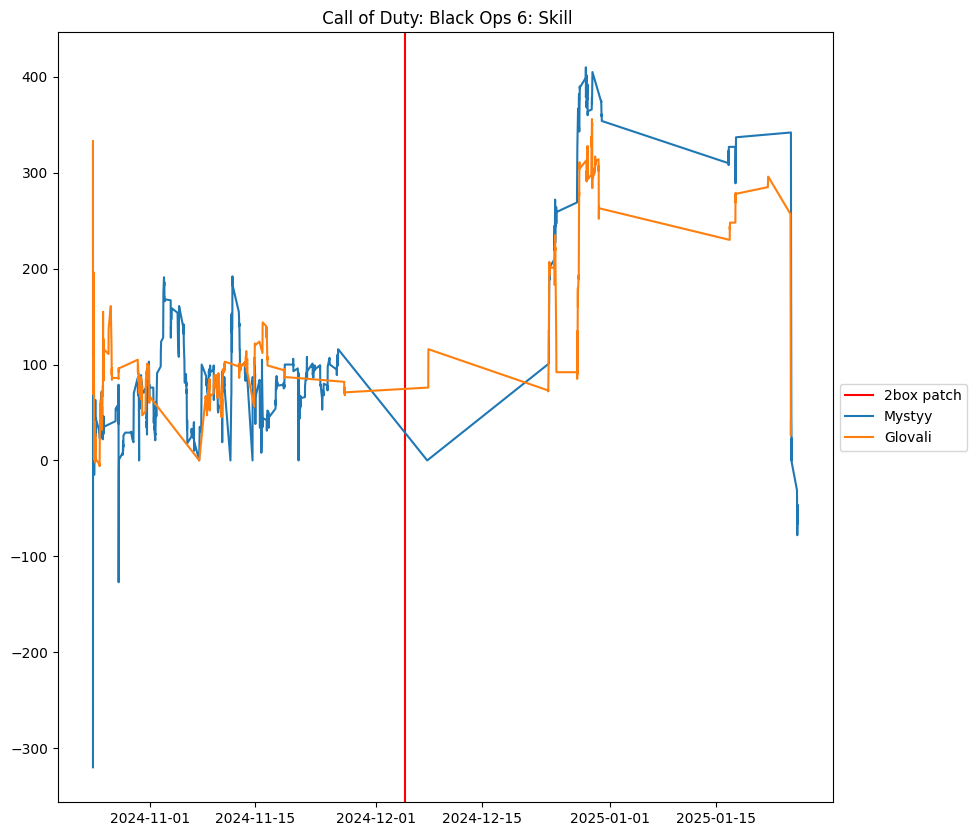

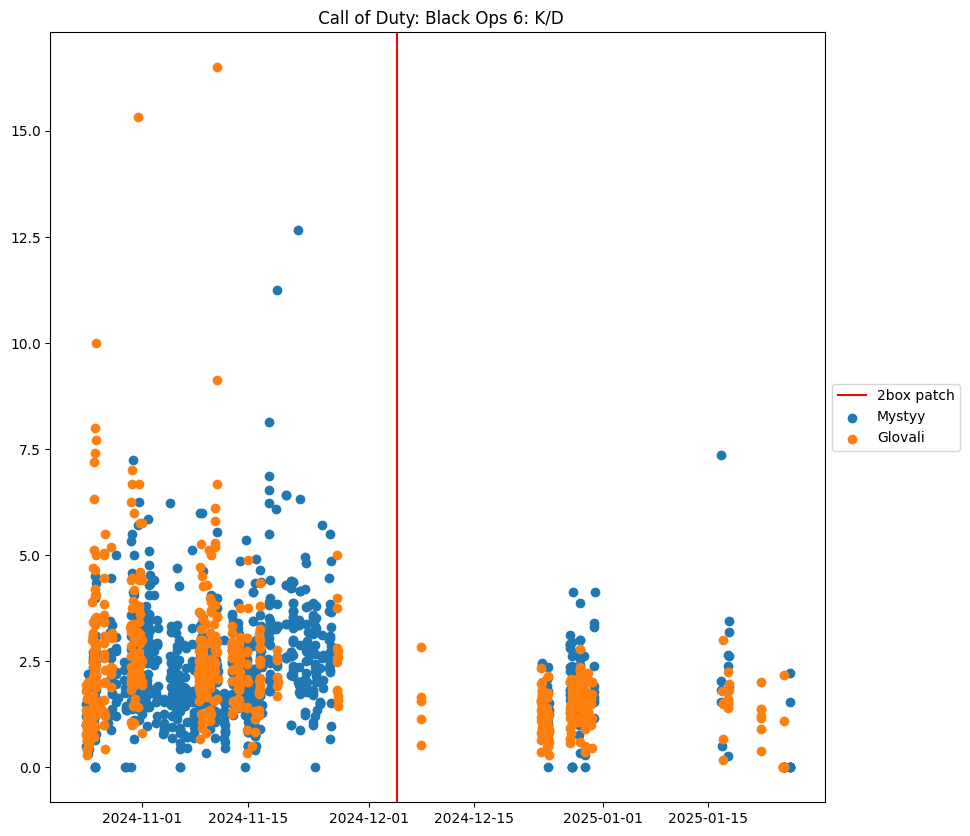

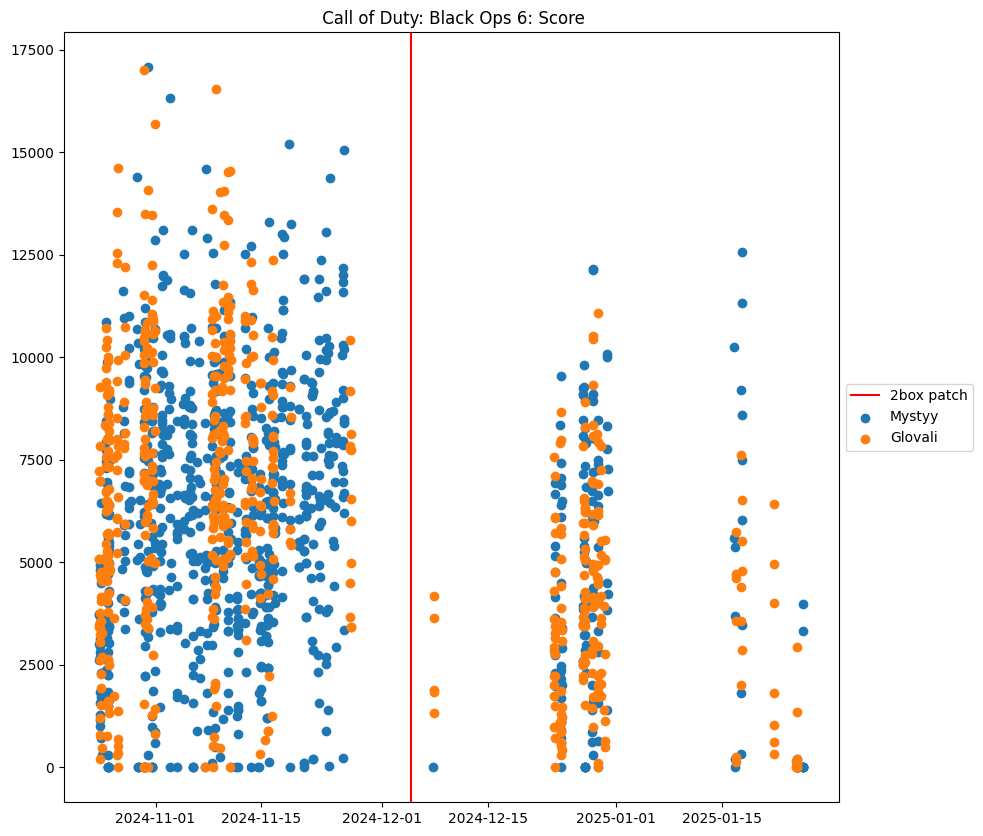

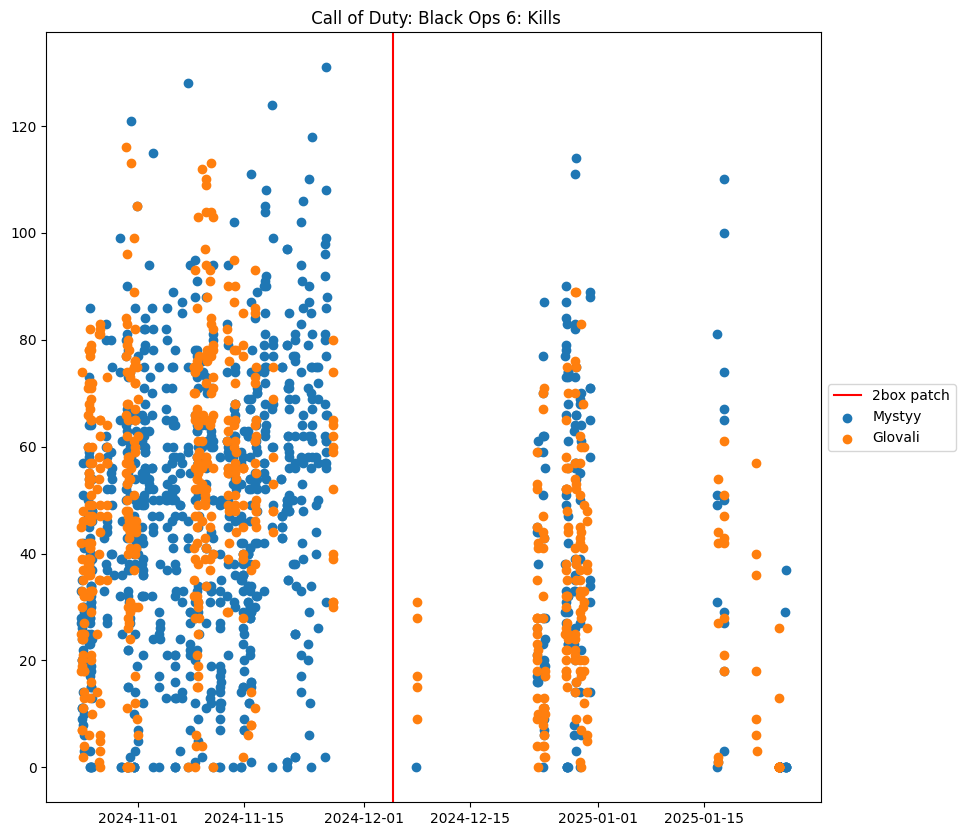

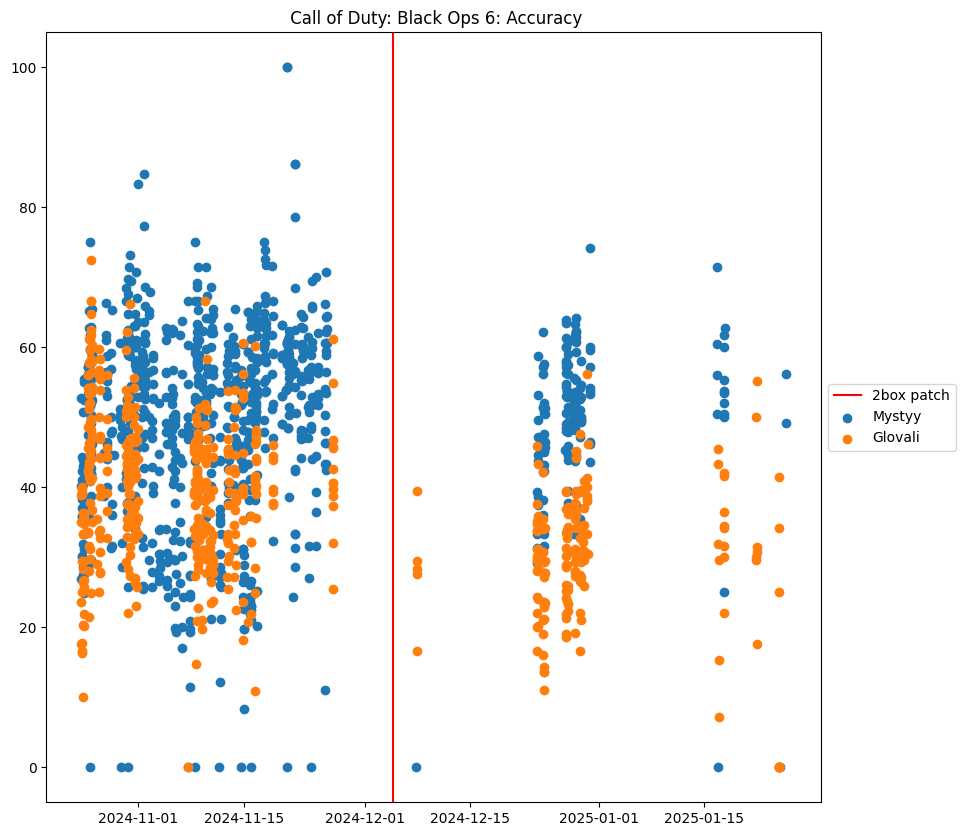

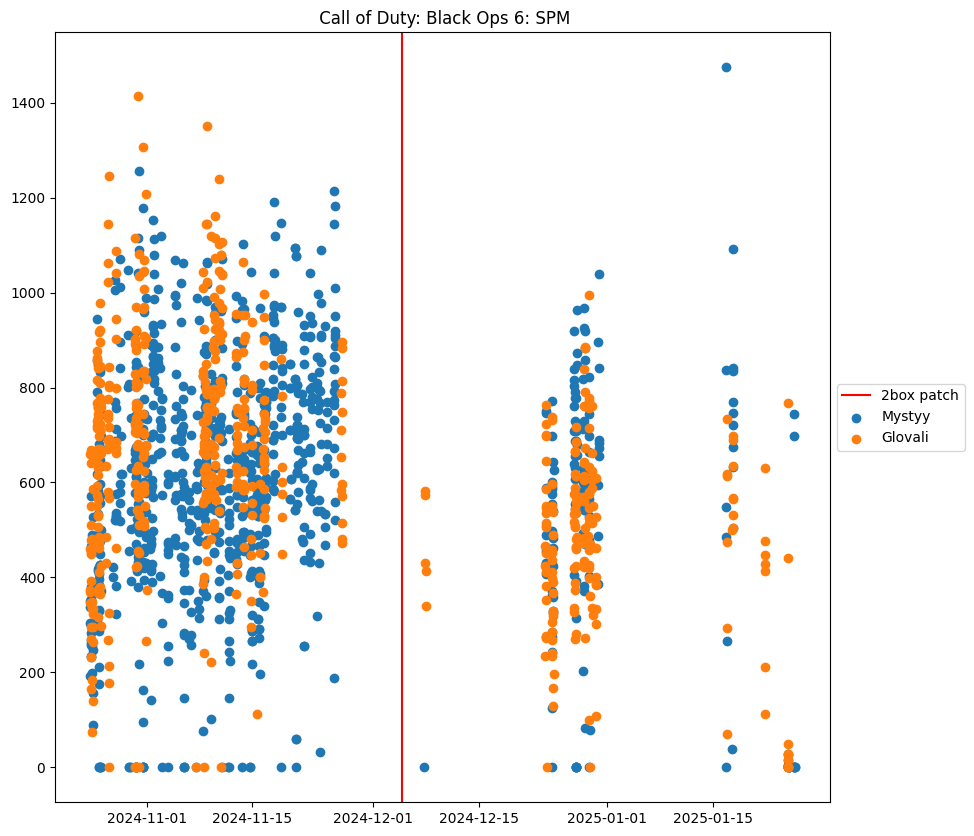

In [14]:
# %matplotlib inline
plot_game(game_name = ' Call of Duty: Black Ops 6') # ranged = ['2024-12-01 00:00:00', '2025-01-01 00:00:00']

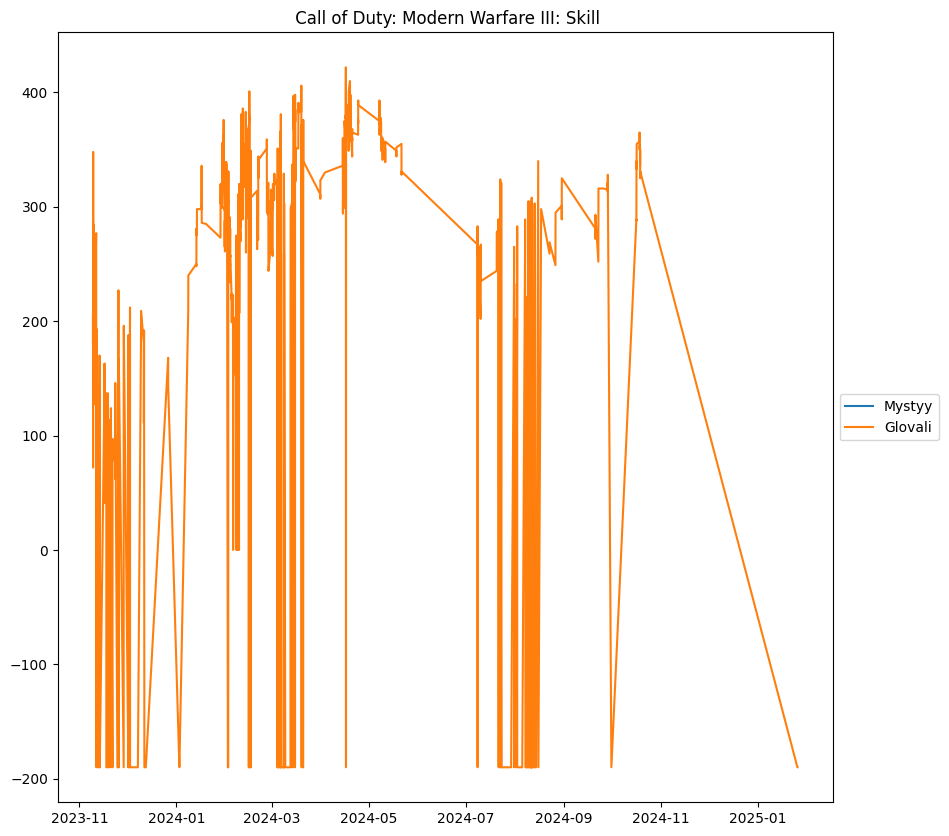

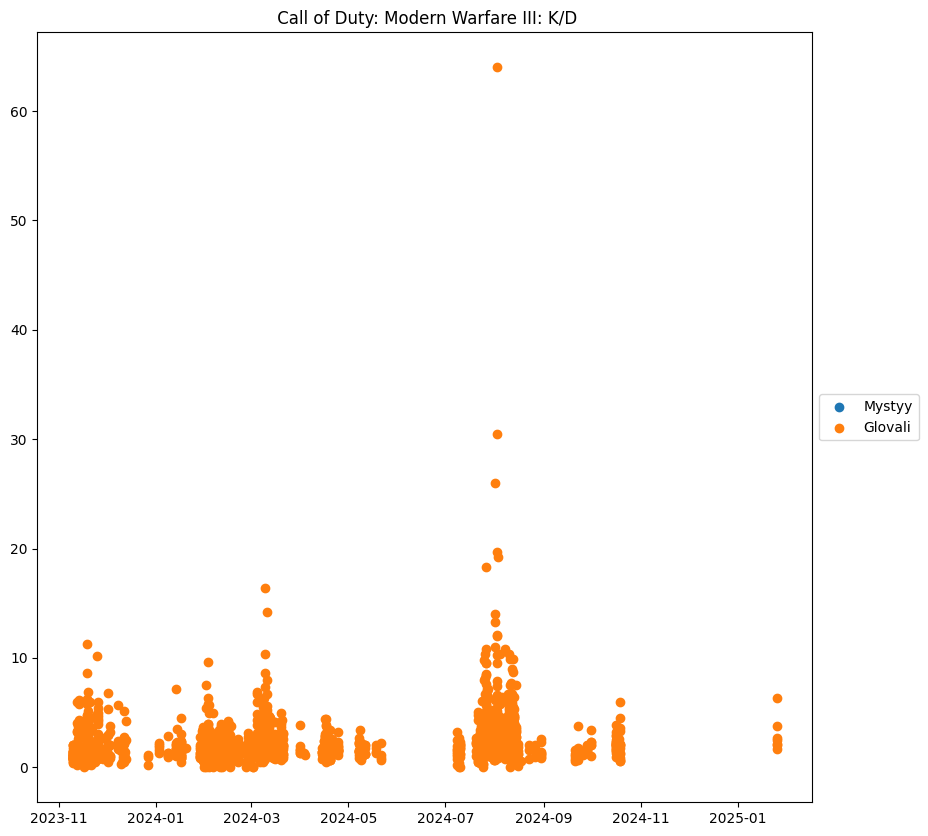

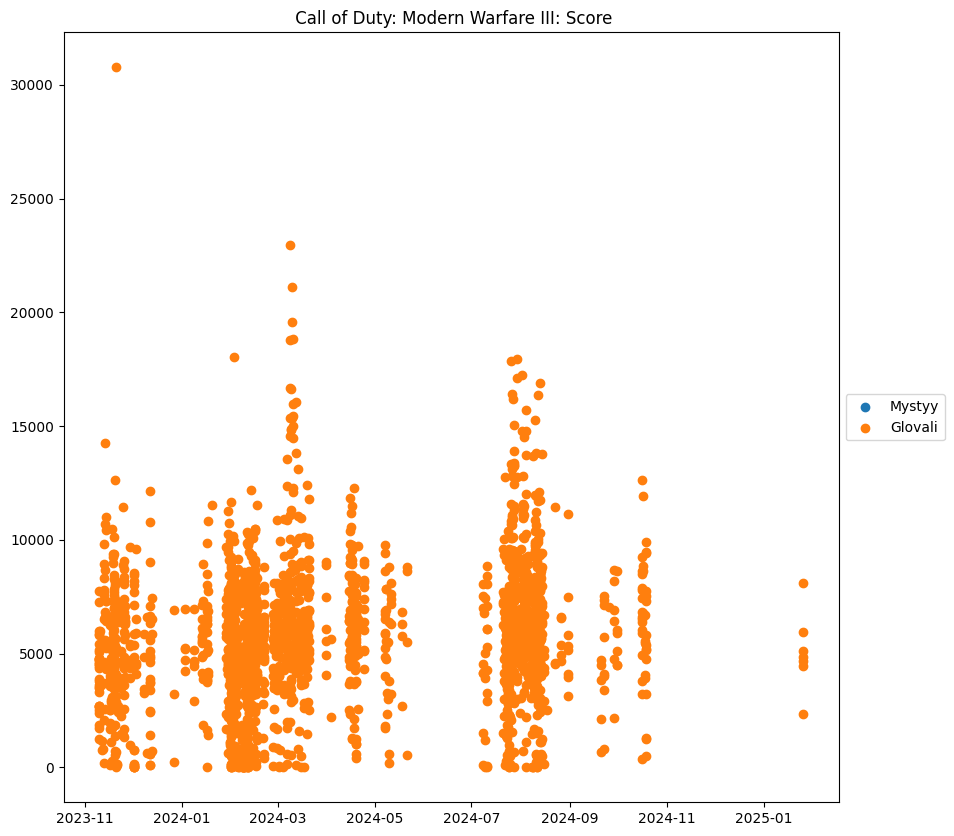

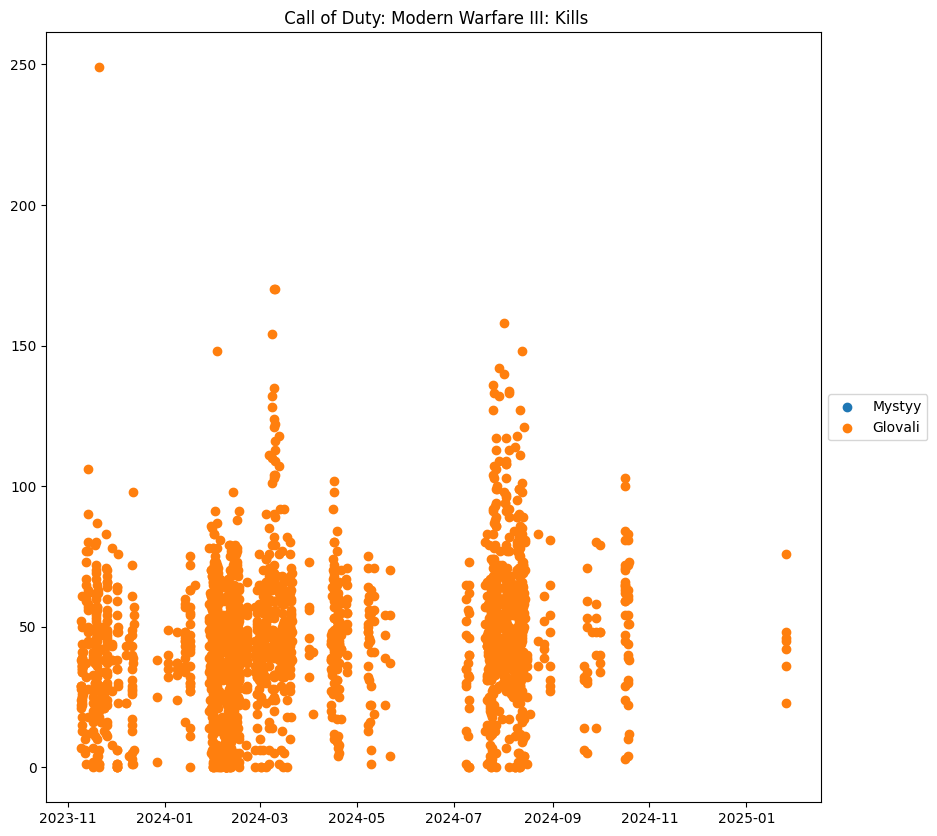

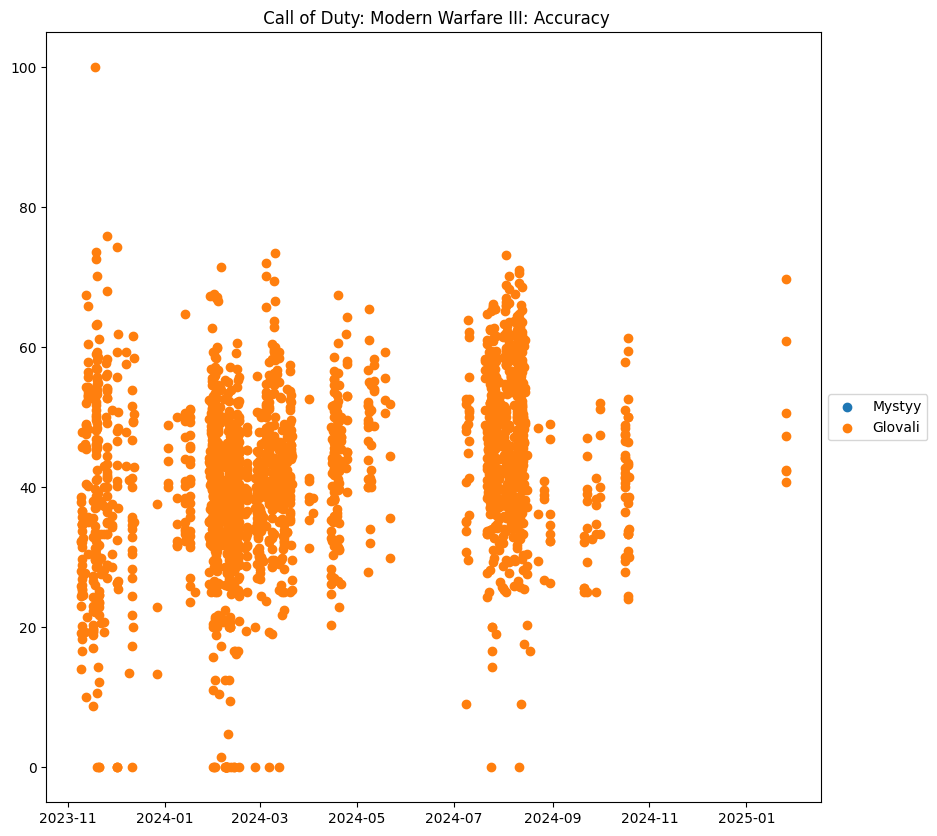

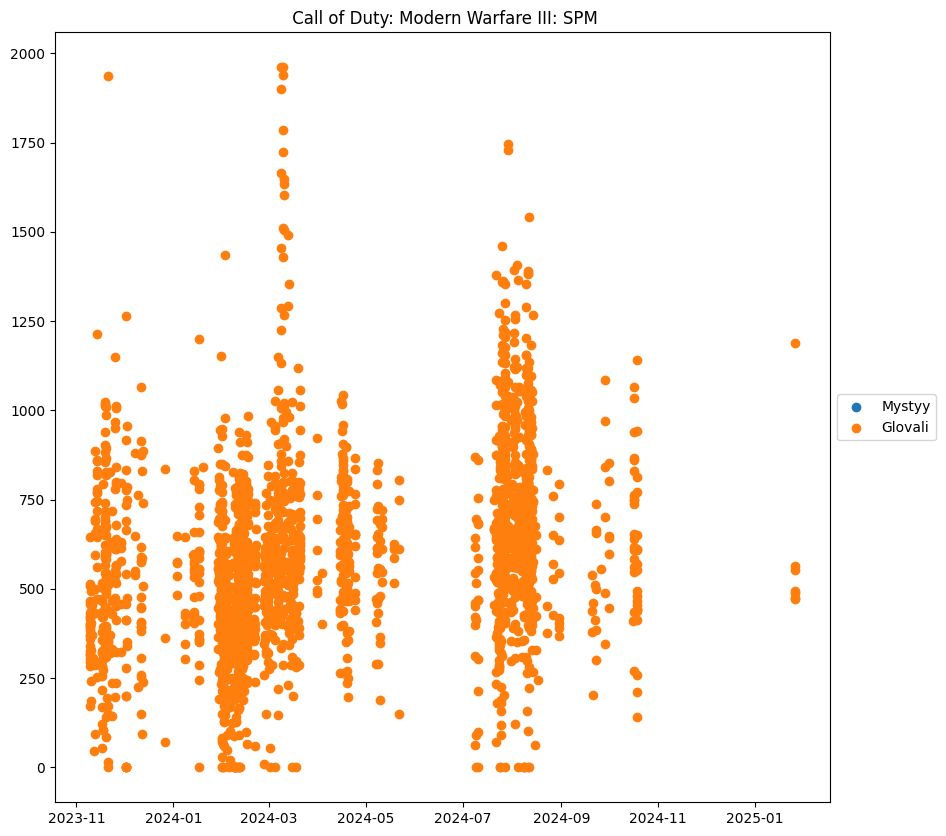

In [15]:
plot_game(game_name = ' Call of Duty: Modern Warfare III')

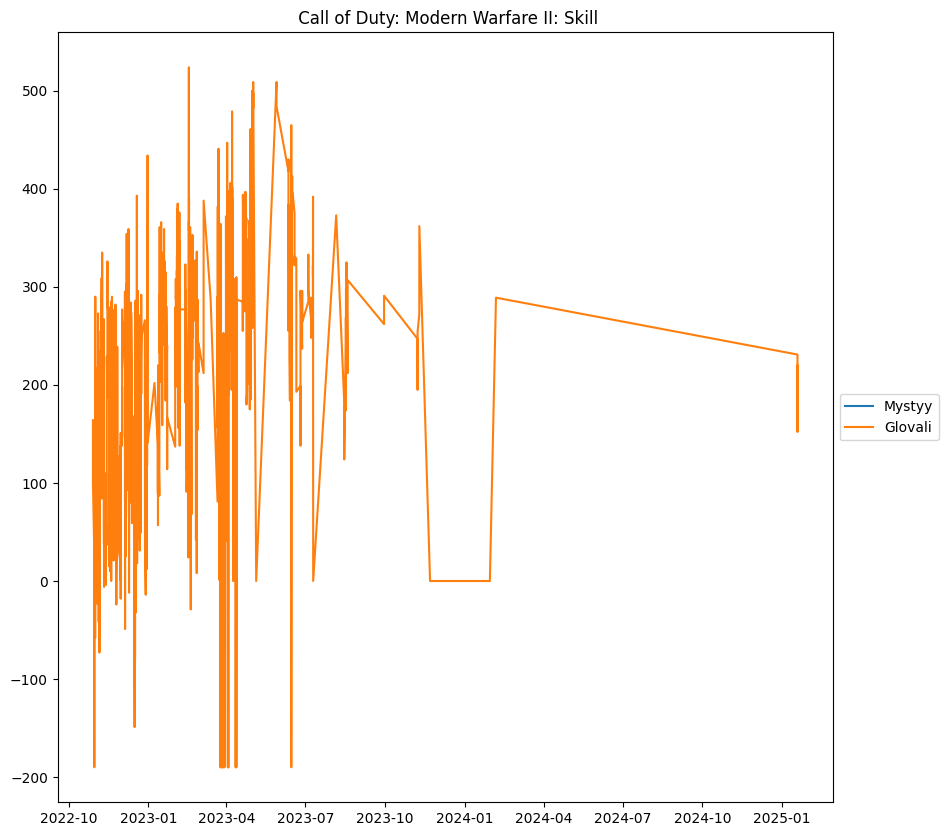

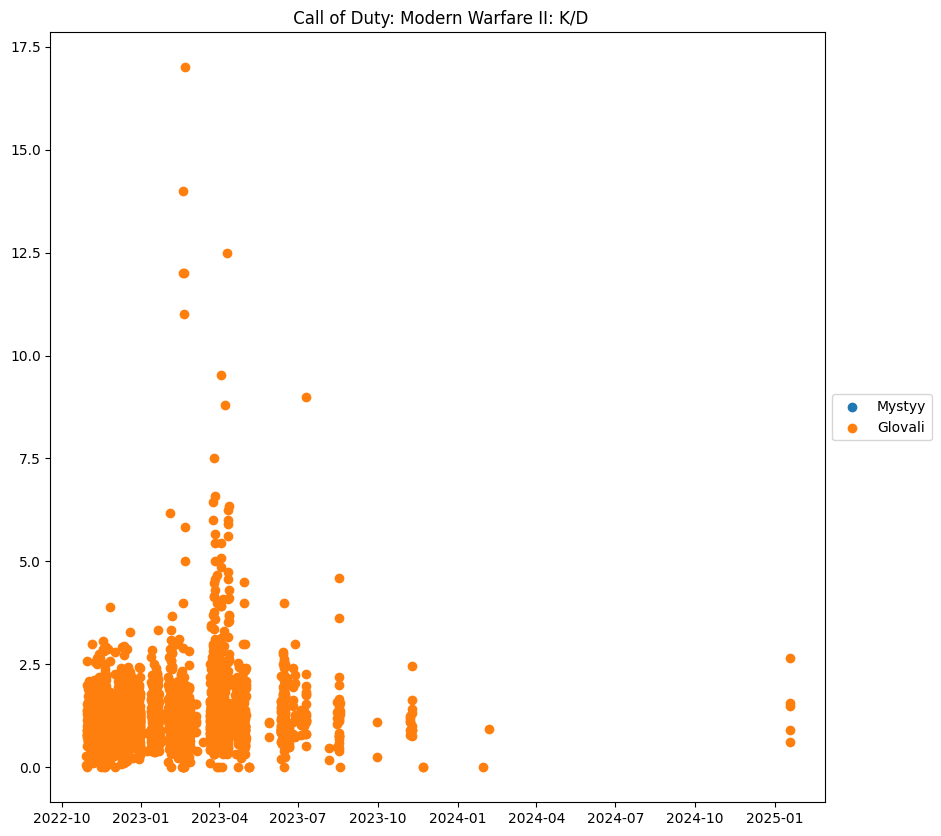

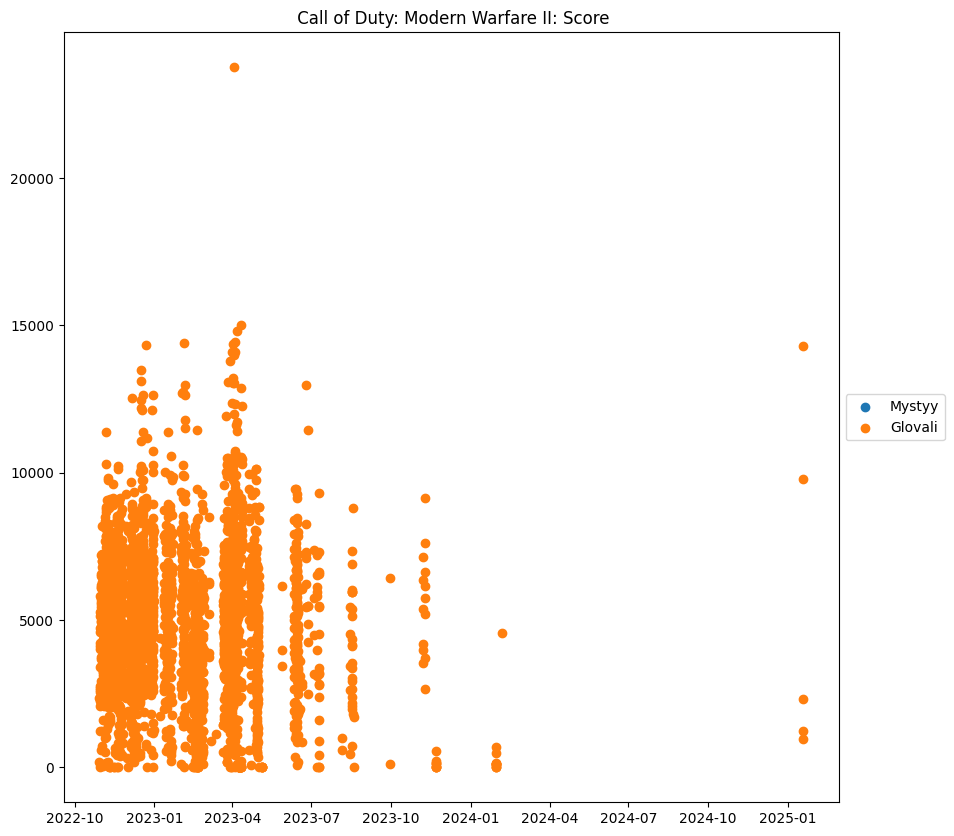

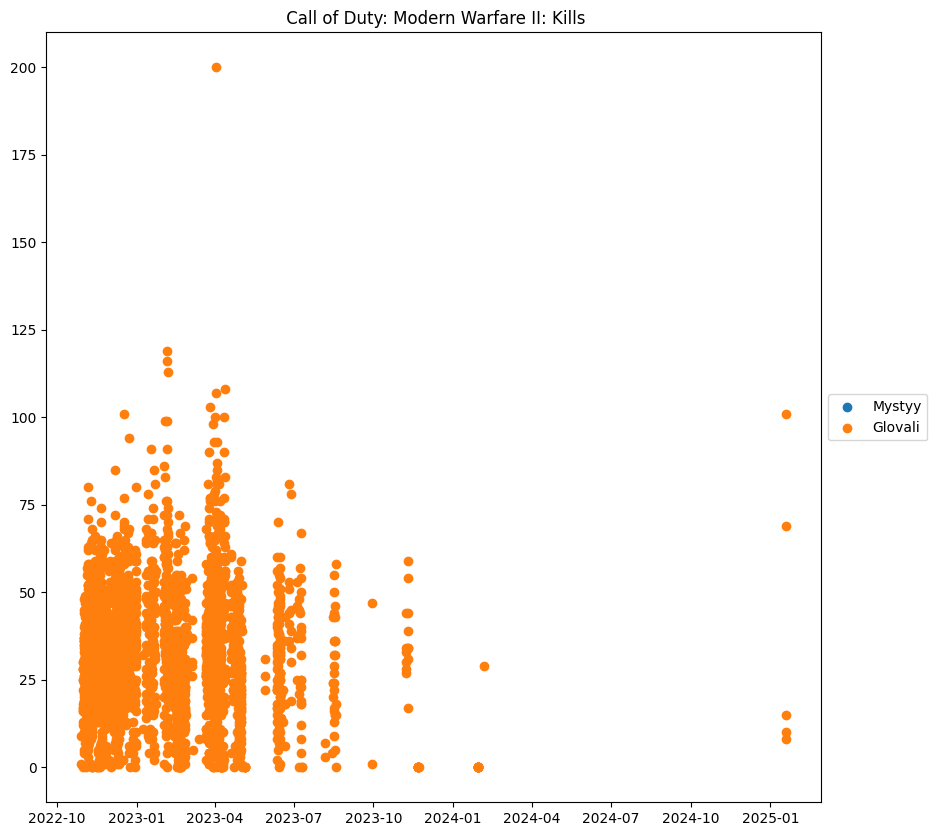

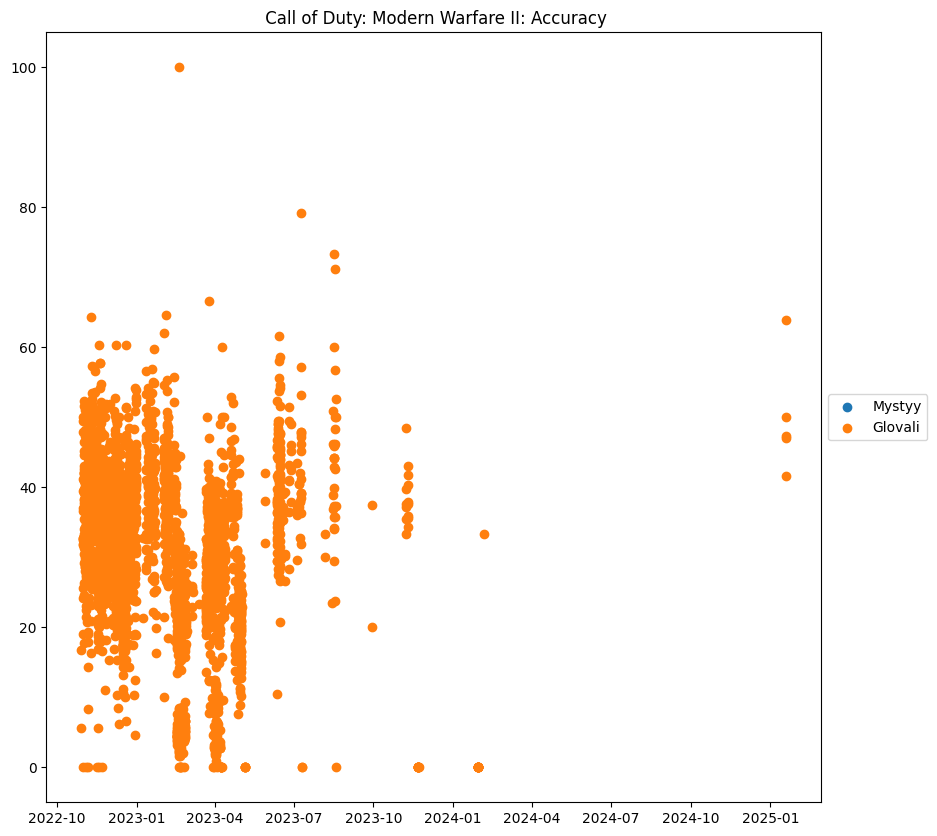

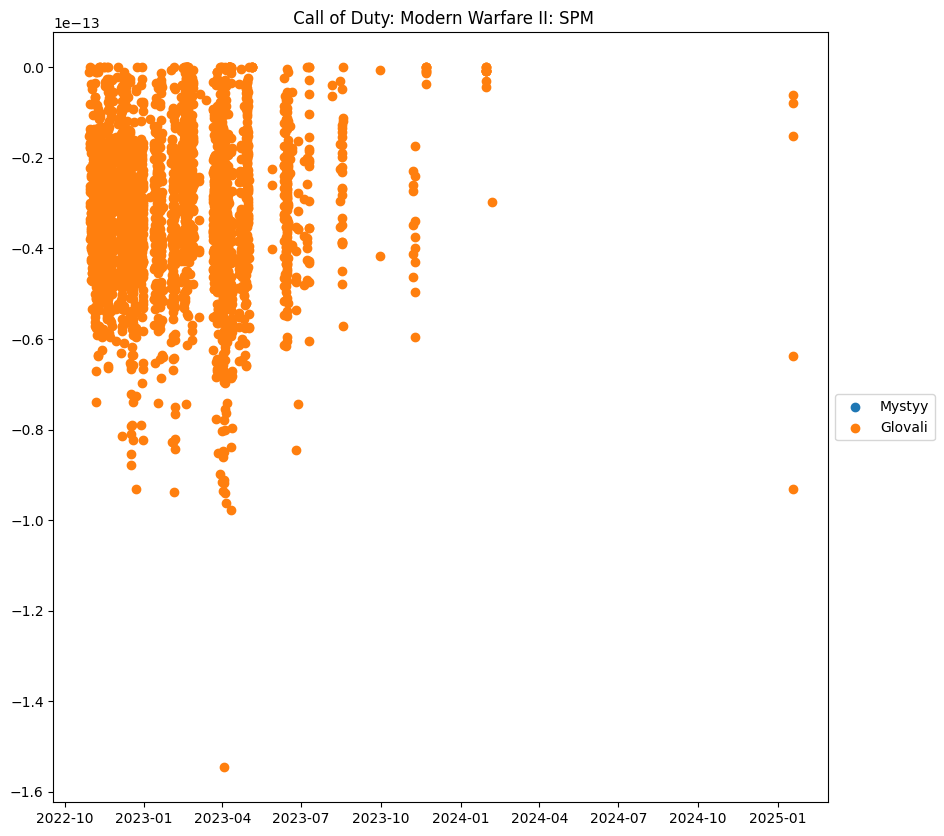

In [16]:
plot_game(game_name = ' Call of Duty: Modern Warfare II')

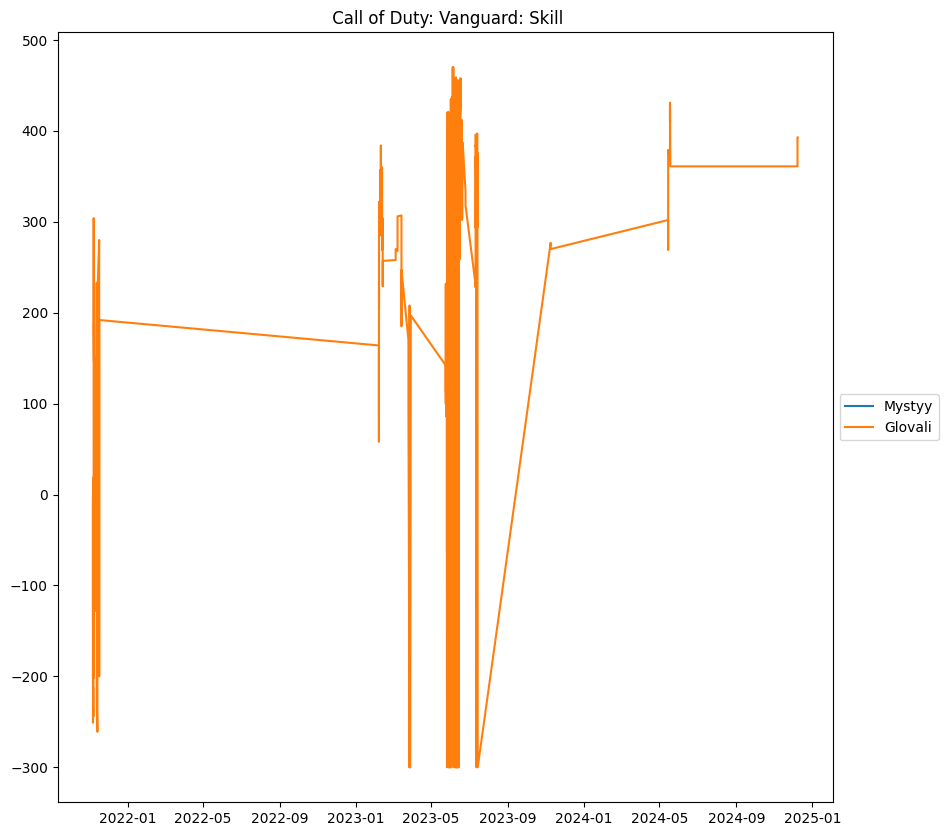

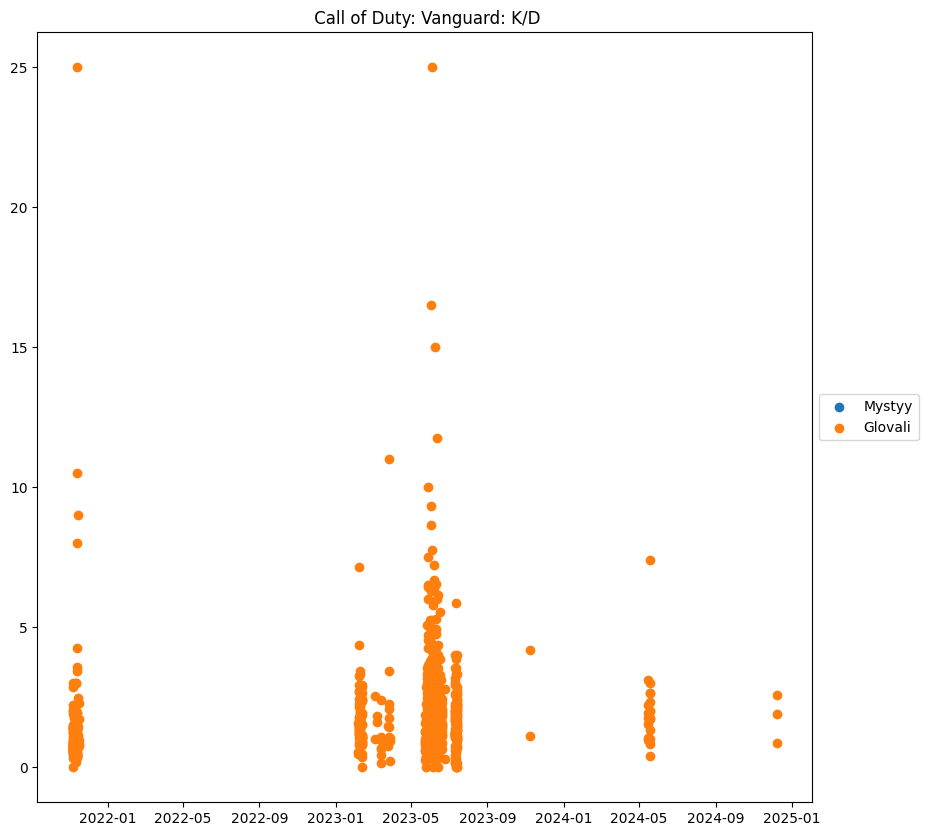

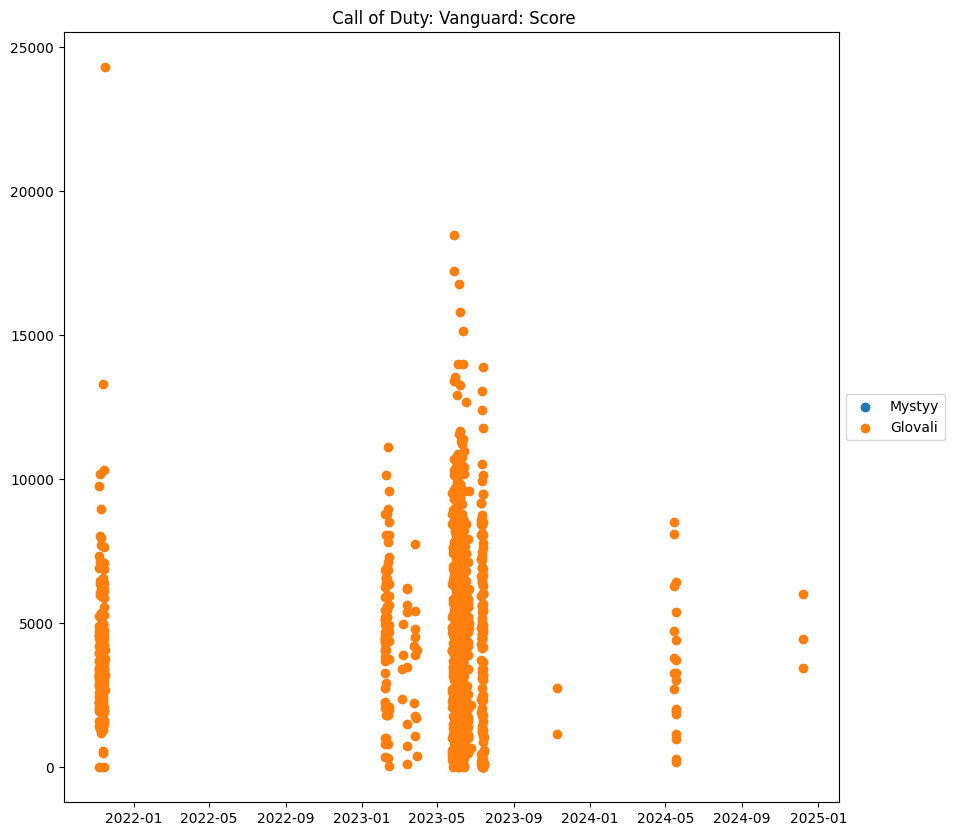

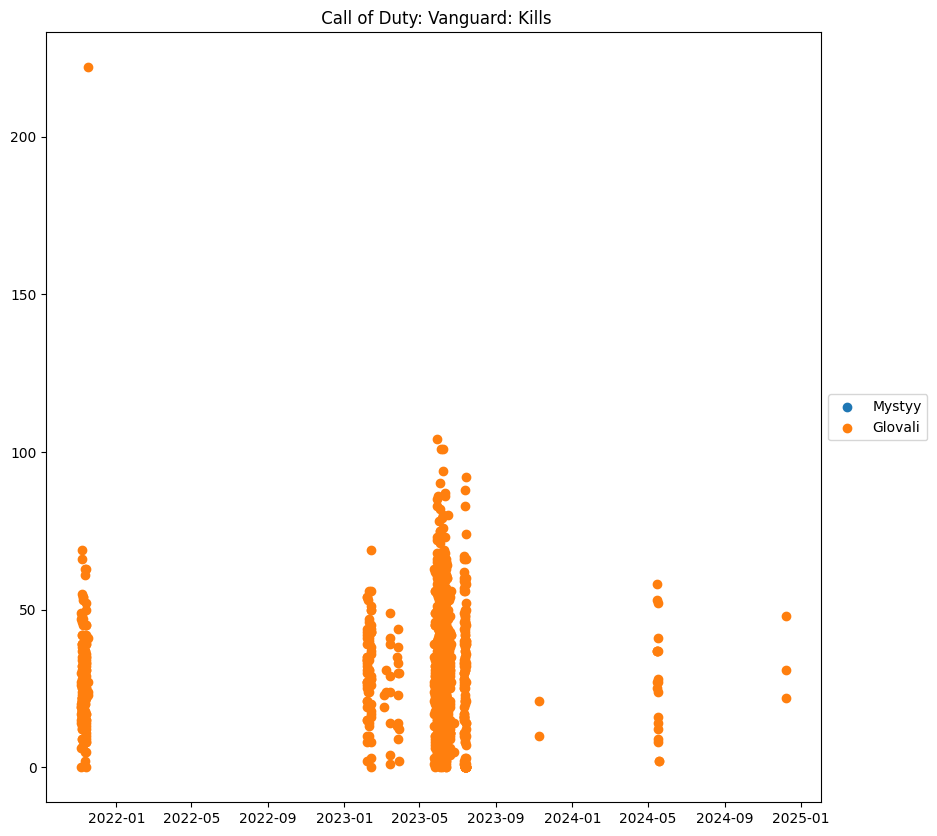

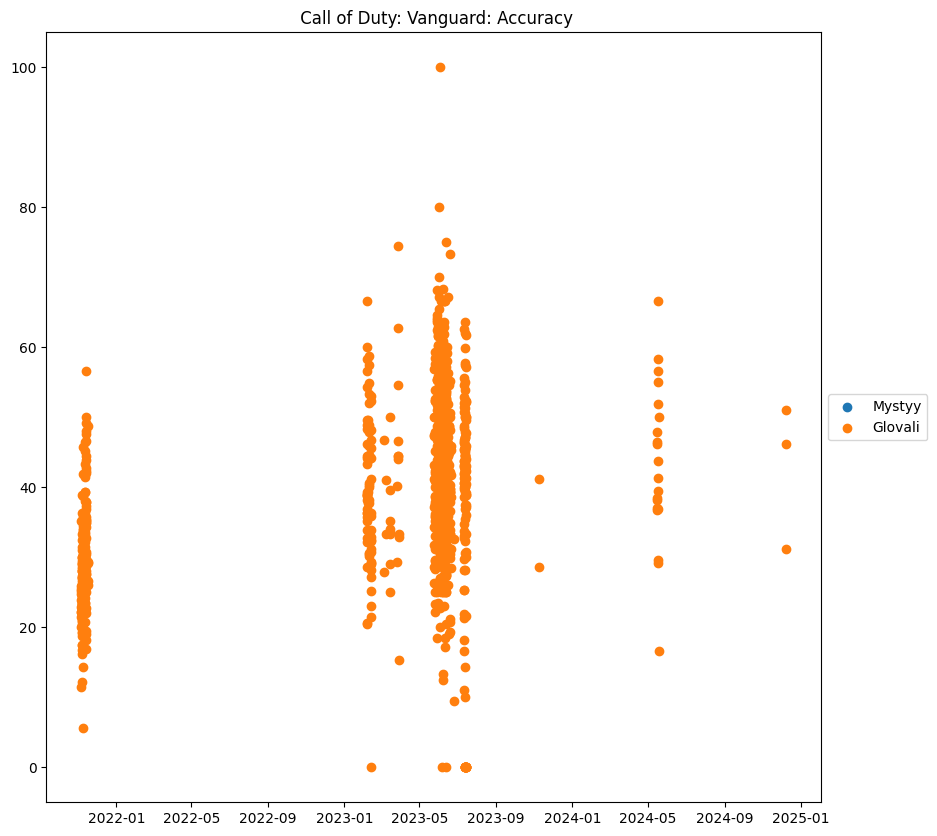

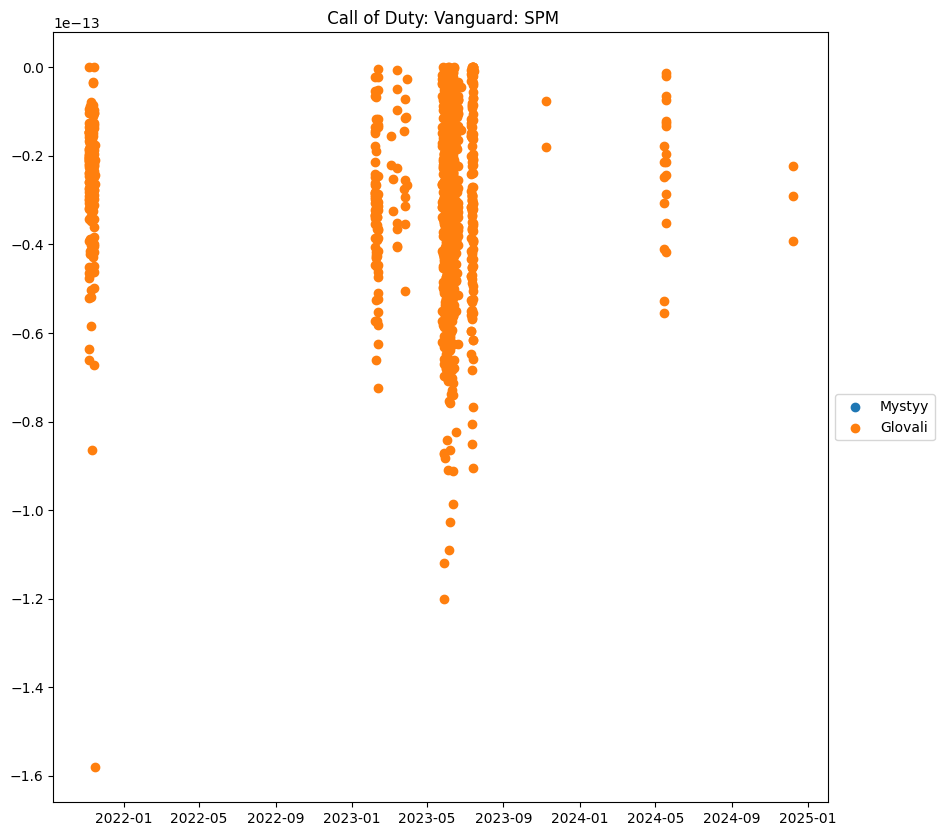

In [17]:
plot_game(game_name = ' Call of Duty: Vanguard')

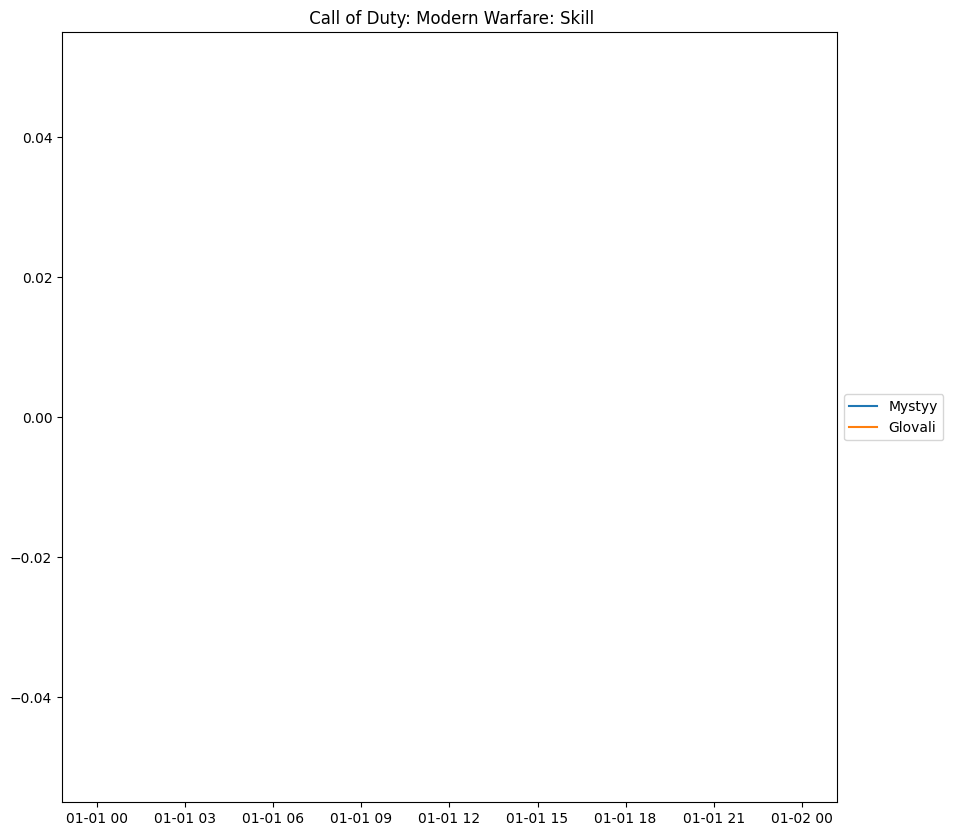

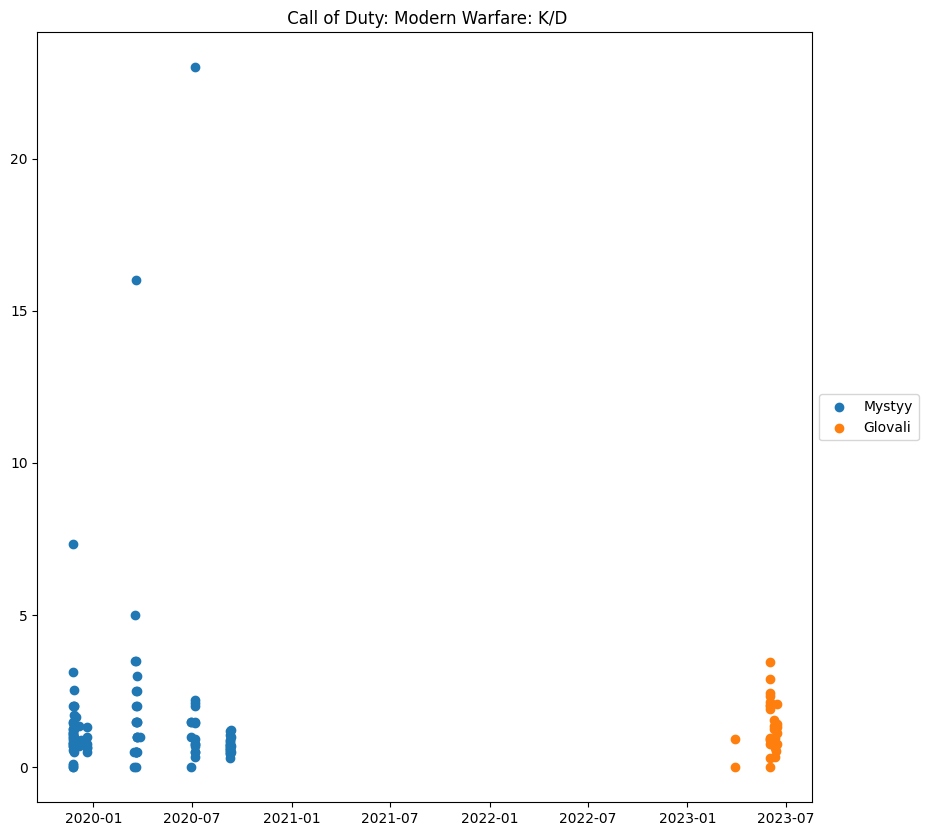

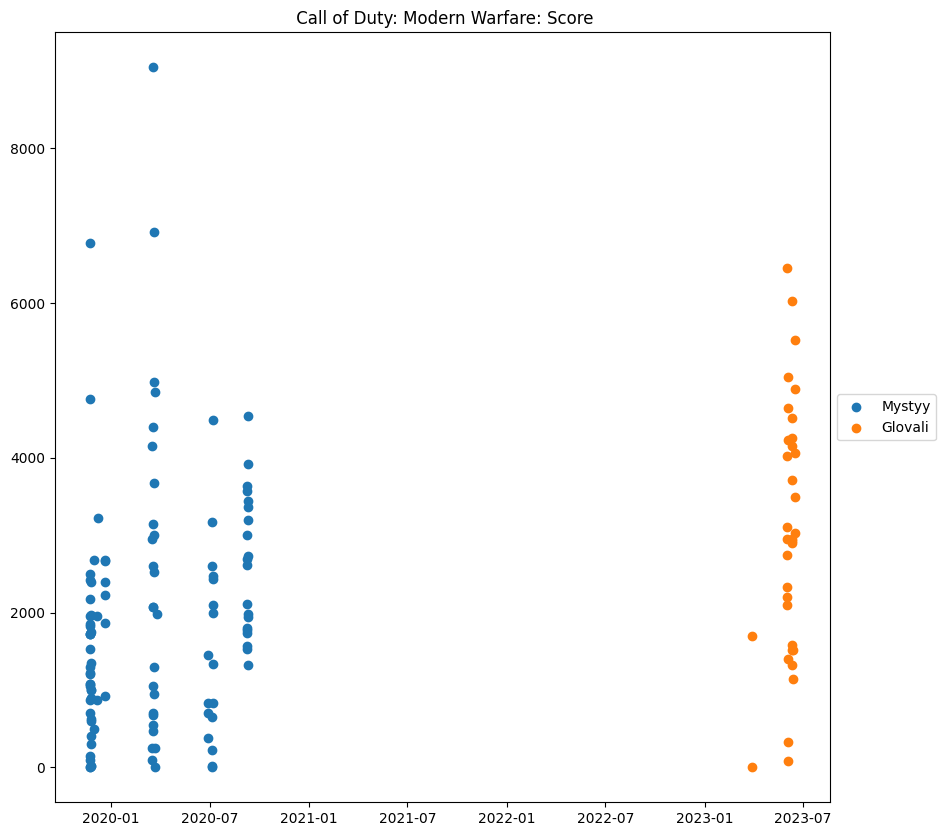

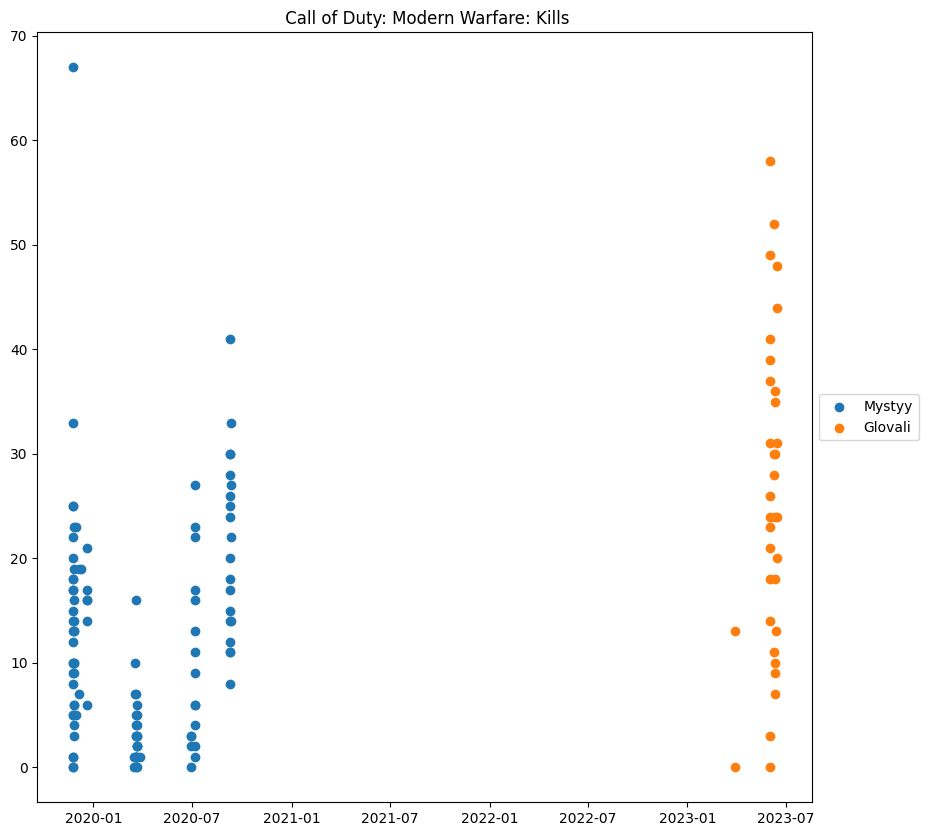

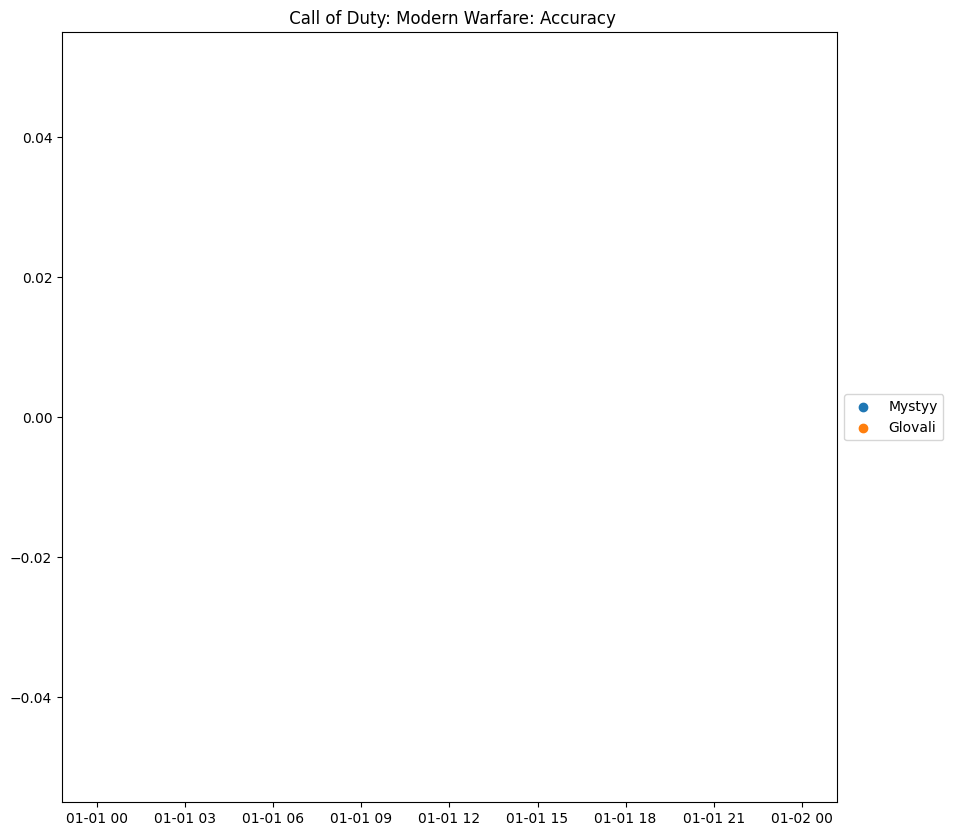

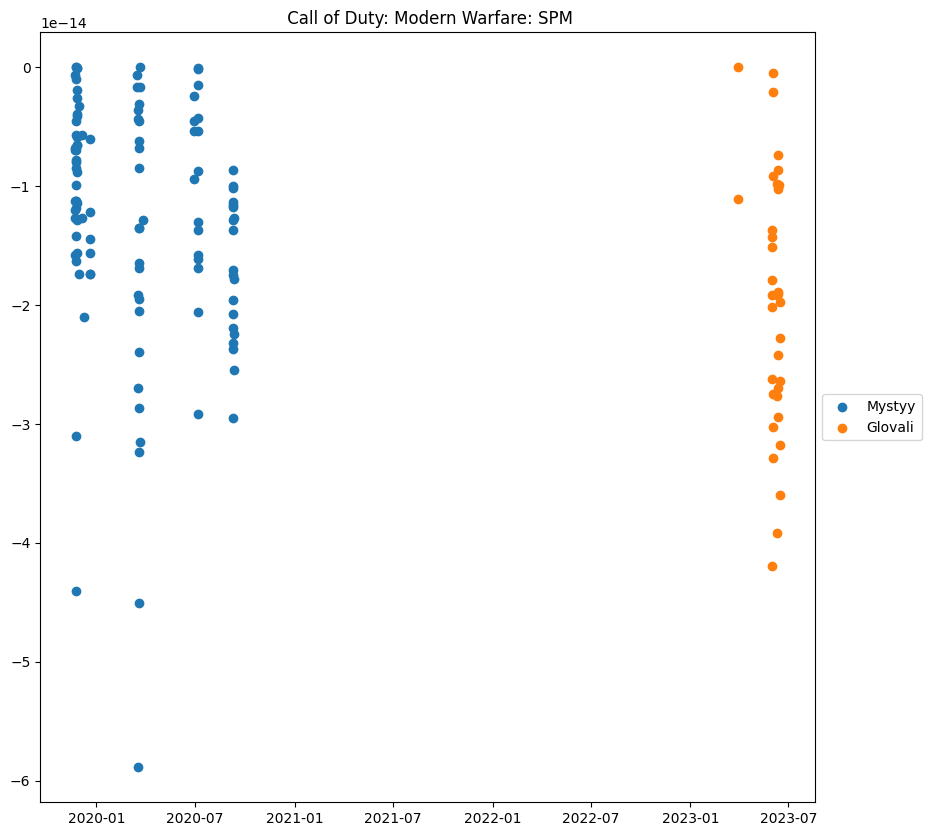

In [18]:
plot_game(game_name = ' Call of Duty: Modern Warfare')